In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle

df = pd.read_csv('/mnt/inca/soc_eu_model/data/002.1_covar_overlayed.tiled.csv',low_memory=False)

# settle the covariate list and target variable
meta_list = ['sample_id','lat','lon','time','ref','oc','ph_h2o','ph_cacl2','bulk_density','clay','silt','sand',
             'caco3','N','K','P','CEC','EC','nuts0','geometry','tile_id']
tgt = 'oc'
covs = [i for i in df.columns if i not in meta_list]

# read in annual covariates
with open('/mnt/inca/soc_eu_model/data/005_covar_annual.static.txt', 'r') as file:
    lines = file.readlines()
covs_annual = [line.strip() for line in lines]



### clean the training dataset by
- clean the target variable
- clean the covariate list

In [2]:
import warnings
warnings.filterwarnings("ignore")

def clean_prop(df, prop, limit):
    print(f'\033[1mCleaning {prop}\033[0m')
    tot = len(df)
    print(f'originally with {tot} rows')
    # Clean NaN
    num = df[prop].isna().sum()
    ccol = df.loc[df[prop].isna()]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with NaN, from {ccol}')
    df = df.dropna(subset=[prop])
    
    # check if there are string values that cannot be converted to numerical values,
    # usually it's <LOD (limit of detection), such as '<6', '<LOD', etc
#     df.loc[:,prop] = pd.to_numeric(df.loc[:,prop], errors='coerce')
    df[prop] = pd.to_numeric(df[prop], errors='coerce')
    num = df[prop].isna().sum()
    ccol = df.loc[df[prop].isna()]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with invalid strings, from {ccol}')
    df = df.dropna(subset=[prop])
    
    # Check for values below 0, which are invalid for all properties
    num = len(df.loc[df[prop] < 0])
    ccol = df.loc[df[prop] < 0]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with {prop} < 0, from {ccol}')
    df = df[df[prop] >= 0]
    
    # check for values higher than plausible limit
    if limit:
        num = len(df.loc[df[prop]>limit])
        ccol = df.loc[df[prop]>limit]['ref'].unique()
        print(f'{num} ({num/tot*100:.2f}%) rows with {prop} > limit values, from {ccol}')
        df = df[df[prop] < limit]
    
    print(f'{len(df)} valid data records left')
    return df


dff = clean_prop(df,'oc',1000)
print()
dff = dff.dropna(subset=covs, how='any')

dff['log1p_oc'] = np.log1p(dff['oc'])
tgt = 'log1p_oc'

print(f'{len(dff)} valid data records left after cleaning covariates')

Cleaning oc
originally with 177792 rows
18009 (10.13%) rows with NaN, from ['portugal.infosolo' 'swiss.nabo' 'foregs' 'nl.bis' 'estonia.kese' 'ukceh'
 'SoDaH' 'gemas' 'croatia.multione' 'netherland.BHR-P' 'Castilla.y.Leon'
 'geocradle' 'MarSOC' 'basque' 'LUCAS']
266 (0.15%) rows with invalid strings, from ['LUCAS']
1405 (0.79%) rows with oc < 0, from ['nl.bis' 'Czech' 'LUCAS' 'Wales.GMEP']
25 (0.01%) rows with oc > limit values, from ['estonia.kese']
158087 valid data records left

152486 valid data records left after cleaning covariates


### feature selection with RFECV

[18:12:44] Finding n_features_to_select using RFECV (repetitions=5 step=15)
[18:12:45] loop 0, training data size: 38121


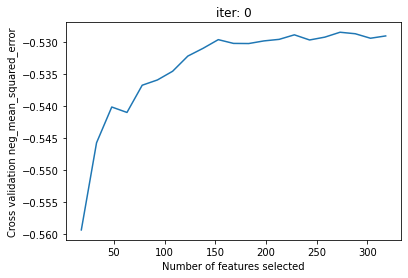

[18:22:27] loop 1, training data size: 38121


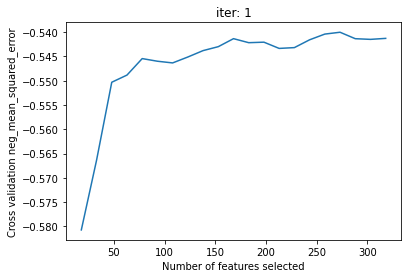

[18:34:23] loop 2, training data size: 38121


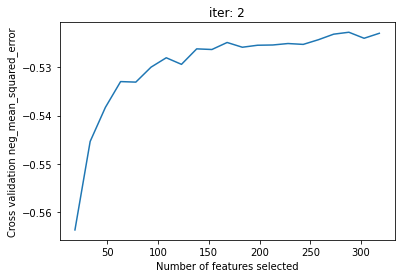

[18:44:38] loop 3, training data size: 38121


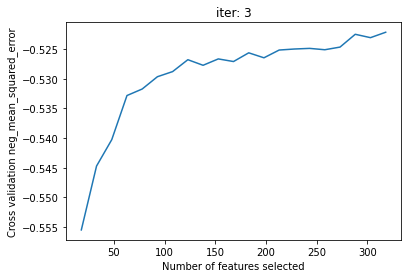

[18:54:49] loop 4, training data size: 38121


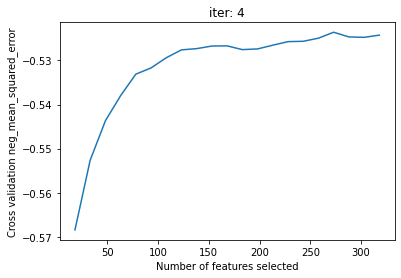

[19:07:33] Finding best features using RFE (n_features_to_select = 273)


In [3]:
# a function to determine optimal number of features

from sklearn.model_selection import GroupKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, RFE
from scipy.signal import argrelmin, argrelmax
import joblib
import random
import multiprocessing

def run_rfecv(data, covs, target_column, scoring, min_feature = 10, errorbar=True, spatial_cv_column = None, n_rep = 5, n_cv = 3, ntrees = 100, local_max_pos = 1):
    
    rfecv_step = int(len(covs) * 0.05)
    random_numbers = [random.randint(0, 99) for _ in range(n_rep)]

    ncpu = multiprocessing.cpu_count()
    if ntrees < ncpu:
        ncpu = ntrees

    ttprint(f"Finding n_features_to_select using RFECV (repetitions={n_rep} step={rfecv_step})")
    
    grid_scores = []
    rfecv_n_features_arr = np.arange(len(covs), min_feature-1, - rfecv_step)[::-1]
    for i in range(0,n_rep):
        # randomly select subsample of the data to do the rfecv
        train, _ = train_test_split(data, test_size=0.75, random_state=random_numbers[i]) 
        ttprint(f'loop {i}, training data size: {len(train)}')
        
        # cross validation with spatial blocking
        cv, groups = KFold(n_cv), None
        if spatial_cv_column is not None:
            cv, groups = GroupKFold(n_cv), train[spatial_cv_column]
        
        # start the RFECV process
        rfecv = RFECV(estimator=RandomForestRegressor(n_estimators=ntrees, n_jobs=ncpu, random_state=random_numbers[i]), cv=cv, step=rfecv_step, 
            min_features_to_select=min_feature, n_jobs=n_cv, scoring=scoring, verbose=0)
        rfecv.fit(train[covs], train[target_column], groups=groups)
        
        # get the score and visualize
        grid_scores += [rfecv.cv_results_['mean_test_score']]
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel(f'Cross validation {scoring}')
        plt.title(f'iter: {i}')
#         print(rfecv.cv_results_["mean_test_score"])
        if errorbar:
            plt.errorbar(
                rfecv_n_features_arr,
                rfecv.cv_results_["mean_test_score"][0:-1],
                yerr=rfecv.cv_results_["std_test_score"][0:-1],
            )
        else:
            plt.plot(rfecv_n_features_arr, rfecv.cv_results_["mean_test_score"][0:-1])
        plt.show()

    rfecv_mean_score = np.mean(np.stack(grid_scores, axis=0), axis=0)
    grid_scores_std = np.std(np.stack(grid_scores, axis=0), axis=0)

#     local_min_arr = argrelmin(rfecv_mean_score, order=1)[0]
#     local_min = local_min_arr[0]
#     if len(local_min_arr) > 1:
#         local_min = local_min_arr[local_min_pos]
    
    local_max_arr = argrelmax(rfecv_mean_score, order=1)[0]
    local_max = local_max_arr[0]
    if len(local_max_arr) > 1:
        local_max = local_max_arr[local_max_pos]
        
    n_features_to_select = rfecv_n_features_arr[local_max]
    
    
    ttprint(f"Finding best features using RFE (n_features_to_select = {n_features_to_select})")
    
    return grid_scores, rfecv_mean_score, grid_scores_std, n_features_to_select 

# rfecv selection
grid_scores, rfecv_mean_score, grid_scores_std, feature_num = run_rfecv(dff, covs, tgt, scoring = 'neg_mean_squared_error', errorbar=False,spatial_cv_column='tile_id')


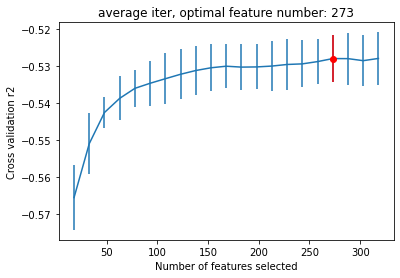

In [8]:
min_feature = 10
rfecv_step = int(len(covs) * 0.05)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel(f'Cross validation r2')
plt.title(f'average iter, optimal feature number: {feature_num}') 

number_arr = np.arange(len(covs), min_feature-1, -rfecv_step)[::-1]

plt.errorbar(number_arr, rfecv_mean_score[0:-1], yerr=grid_scores_std[0:-1])

specific_index = np.where(number_arr == feature_num)[0][0]

plt.errorbar(
    feature_num,
    rfecv_mean_score[specific_index],
    yerr=grid_scores_std[specific_index],
    fmt='o', color='red', label=f'Optimal feature number')
    
plt.show()

##### Determine the optimal set of covariate number with RFE

In [18]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, n_jobs=70, random_state=0),
          step=int(len(covs) * 0.02),
          n_features_to_select=feature_num,
          verbose=0)

# train, _ = train_test_split(dff, test_size=0.5, random_state=42, stratify=dff['tile_id'])
train = dff.groupby('tile_id', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))

rfe.fit(train[covs], train[tgt].values)

selected_features = np.array(covs)[rfe.support_]

# get the feature importance
rf = RandomForestRegressor(n_estimators=50, n_jobs=80, random_state=0)
rf.fit(train[selected_features], train[tgt].values)
# train_r2 = rf.score(train_set[selected_features], train_set[tgt].values)
# test_r2 = rf.score(test_set[selected_features], test_set[tgt].values)
# print("Training R^2 score:", train_r2)
# print("Testing R^2 score:", test_r2)

importances = rf.feature_importances_
feature_importances = dict(zip(selected_features, importances))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
feature_importances = dict(feature_importances)

with open('/mnt/inca/soc_eu_model/data/003.1_selected.covar_all.rfecv.txt', 'w') as file:
    for item in selected_features:
        file.write(f"{item}\n")
     
feature_importances

{'clm_bioclim.var_chelsa.gdd10_m_1km_s0..0cm_1981..2010_v2.1': 0.21145576417564257,
 'hzn_btm': 0.07854920018123296,
 'ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127': 0.03802405849338994,
 'red_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127': 0.028357217973930635,
 'hzn_top': 0.018522323908667516,
 'clm_bioclim.var_chelsa.bio12_m_1km_s0..0cm_1981..2010_v2.1': 0.01829060905783201,
 'dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230210': 0.016211413530930665,
 'clm_bioclim.var_chelsa.gsp_m_1km_s0..0cm_1981..2010_v2.1': 0.015842044575101143,
 'ndti_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127': 0.010111035026938003,
 'clm_bioclim.var_chelsa.bio10_m_1km_s0..0cm_1981..2010_v2.1': 0.006643797327686084,
 'clm_accum.precipitation_chelsa.montlhy_m_1km_s0..0cm_{year}.10.01..{year}.10.31_v2.1': 0.004805954083575559,
 'nir_glad.landsat.seasconv_m_30m_s_

### with only annual and static covariates

[20:00:07] Finding n_features_to_select using RFECV (repetitions=5 step=7)
[20:00:07] loop 0, training data size: 38121


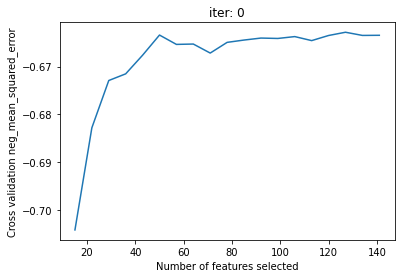

[20:03:53] loop 1, training data size: 38121


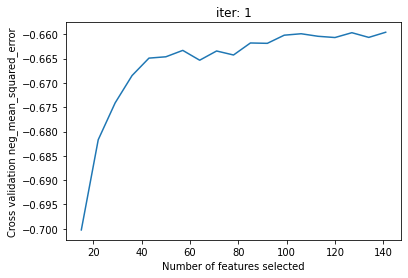

[20:06:38] loop 2, training data size: 38121


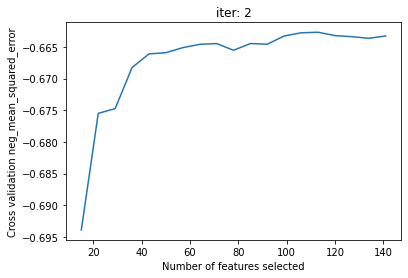

[20:10:29] loop 3, training data size: 38121


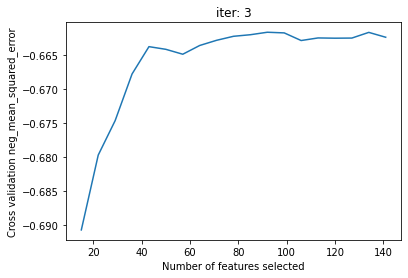

[20:15:45] loop 4, training data size: 38121


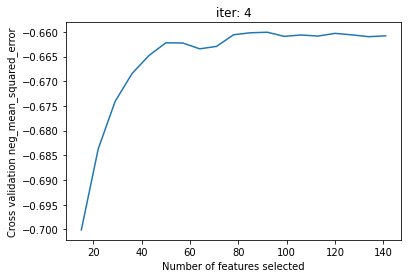

[20:18:26] Finding best features using RFE (n_features_to_select = 106)


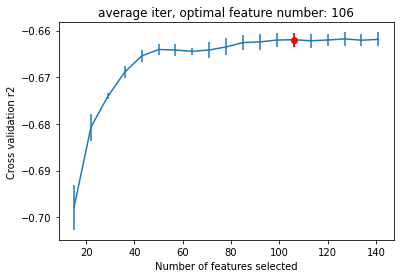

In [19]:
# rfecv selection for annual covariates set
grid_scores, rfecv_mean_score, grid_scores_std, feature_num = run_rfecv(dff, covs_annual, tgt, scoring ='neg_mean_squared_error',errorbar=False,spatial_cv_column='tile_id')

# visualize
min_feature = 10
rfecv_step = int(len(covs_annual) * 0.05)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel(f'Cross validation r2')
plt.title(f'average iter, optimal feature number: {feature_num}') 

number_arr = np.arange(len(covs_annual), min_feature-1, -rfecv_step)[::-1]

plt.errorbar(number_arr, rfecv_mean_score[0:-1], yerr=grid_scores_std[0:-1])

specific_index = np.where(number_arr == feature_num)[0][0]

plt.errorbar(
    feature_num,
    rfecv_mean_score[specific_index],
    yerr=grid_scores_std[specific_index],
    fmt='o', color='red', label=f'Optimal feature number')
    
plt.show()

In [20]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, n_jobs=70, random_state=0),
          step=int(len(covs_annual) * 0.02),
          n_features_to_select=feature_num,
          verbose=0)

rfe.fit(train[covs_annual], train[tgt].values)

selected_features = np.array(covs_annual)[rfe.support_]

# get the feature importance
rf = RandomForestRegressor(n_estimators=50, n_jobs=80, random_state=0)
rf.fit(train[selected_features], train[tgt].values)

# train_r2 = rf.score(train_set[selected_features], train_set[tgt].values)
# test_r2 = rf.score(test_set[selected_features], test_set[tgt].values)
# print("Training R^2 score:", train_r2)
# print("Testing R^2 score:", test_r2)

importances = rf.feature_importances_
feature_importances = dict(zip(selected_features, importances))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
feature_importances = dict(feature_importances)

with open('/mnt/inca/soc_eu_model/data/003.2_selected.covar_annual.rfecv.txt', 'w') as file:
    for item in selected_features:
        file.write(f"{item}\n")
        
feature_importances

{'clm_bioclim.var_chelsa.gdd10_m_1km_s0..0cm_1981..2010_v2.1': 0.22091735133560164,
 'ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127': 0.062001467425281245,
 'dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230210': 0.027534132418219323,
 'clm_bioclim.var_chelsa.gsp_m_1km_s0..0cm_1981..2010_v2.1': 0.025786624940190624,
 'clm_accum.precipitation_chelsa.annual_m_1km_s0..0cm_{year}_v2.1': 0.023558699403982492,
 'wv_mcd19a2v061.seasconv.m.yearly_sd_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619': 0.01878538684756731,
 'wv_mcd19a2v061.seasconv.m.yearly_p75_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619': 0.01764083567440266,
 'clm_bioclim.var_chelsa.bio15_m_1km_s0..0cm_1981..2010_v2.1': 0.01675340167173542,
 'red_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127': 0.016248073347829416,
 'wv_mcd19a2v061.seasconv.m.yearly_p50_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619': 0.01568152866